In [1]:
%matplotlib inline
import tensorflow.keras.backend as K
import tensorflow.keras as keras
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_score,confusion_matrix,accuracy_score
from sklearn.decomposition import  PCA,TruncatedSVD,FastICA
from tensorflow.keras.applications import VGG16, ResNet50,VGG19,ResNet50V2,EfficientNetB0
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import soundfile as sf
from pathlib import *
import pandas as pd
import numpy as np
import librosa
import glob
import shutil
import os


In [2]:
INPUT_PATH = Path('/net/store/cbc/projects/Pan troglodytes/audio_PH_dataset/PH/good_data/')
file_path =  '/net/store/cv/users/ybrima/scratch/data/Luango_Speaker/clip_loango.npz'
BASE_PATH =  '/net/store/cv/users/ybrima/scratch/data/Luango_Speaker/'
CLEAN_PATH =  Path(BASE_PATH,'good_data')
FRAME_LENGHT =  1024
SAMPLE_RATE =  44100
HOP_LENGTH =  512

In [3]:
def get_classes():
    C = []
    for d in os.listdir(INPUT_PATH):
        temp =  Path(INPUT_PATH, d)
        if(os.path.isdir(temp) and len(glob.glob(f"{temp}/*.wav")) > 0):
            C.append(d)
    return C

In [4]:
CLASSES =  get_classes()

In [5]:
def get_files(INPUT_PATH):
    ds =  {'file': [], 'class': [], 'label':  [], 'duration': [],'sr': []}
    for d in os.listdir(INPUT_PATH):
        temp =  Path(INPUT_PATH, d)
        if(os.path.isdir(temp)):
            for file in temp.glob("**/*.wav"):
                filename =  Path(temp,file)
                y,sr = librosa.load(filename, sr=None)
                TRACK_DURATION = (1/SAMPLE_RATE)* len(y) # measured in seconds
                ds['file'].append(filename)
                ds['class'].append(CLASSES.index(d))
                ds['label'].append(d)
                ds['duration'].append(librosa.get_duration(y,sr))
                ds['sr'].append(sr)
    data = pd.DataFrame(ds)
    data.to_csv(Path(BASE_PATH,'metadata.csv'), index=False)
    print(f"{data.shape[0]} files read successfully")
    return data

In [6]:
df = get_files(INPUT_PATH)

83 files read successfully


In [7]:
len(CLASSES)

10

In [8]:
df['class'].value_counts()

0    15
1    14
5    11
3    10
4     7
7     7
8     7
6     5
9     5
2     2
Name: class, dtype: int64

In [9]:
df.head()

,file,class,label,duration,sr
0,/net/store/cbc/projects/Pan troglodytes/audio_...,0,PAN,40.105215,44100
1,/net/store/cbc/projects/Pan troglodytes/audio_...,0,PAN,9.431655,44100
2,/net/store/cbc/projects/Pan troglodytes/audio_...,0,PAN,21.143220,44100
3,/net/store/cbc/projects/Pan troglodytes/audio_...,0,PAN,17.011519,44100
4,/net/store/cbc/projects/Pan troglodytes/audio_...,0,PAN,22.009615,44100


In [10]:
df['label'].value_counts()


PAN    15
THE    14
FRE    11
ARN    10
LOU     7
CHE     7
NGO     7
CHI     5
LIT     5
GUM     2
Name: label, dtype: int64

In [14]:
CLASSES

['PAN', 'THE', 'GUM', 'ARN', 'CHE', 'FRE', 'LIT', 'LOU', 'NGO', 'CHI']

In [28]:
def build_dataset(INPUT_PATH, dur=1):
    X = []
    label = []
    Z = []
    for d in os.listdir(INPUT_PATH):
        temp =  Path(INPUT_PATH, d)
        if(os.path.isdir(temp) and len(os.listdir(temp)) > 0):
            for file in temp.glob("**/*.wav"):
                filename =  Path(temp,file)
                y,sr = librosa.load(filename, sr=None)
                for i in range(0, len(y), sr*dur):
                  x = y[i:i+ (sr*dur)]
                  if(x.shape[0] < sr*dur):
                    z = np.zeros( abs(x.shape[0] -  (sr*dur)) )
                    x =  np.concatenate([x, z ])
                  D = librosa.stft(x,hop_length=HOP_LENGTH,n_fft= FRAME_LENGHT//4)  # STFT of y
                  S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
                  Z.append(x)
                  X.append(S_db)
                  label.append(CLASSES.index(d))
    print(f"{len(X)}  {dur} second audio samples created successfully")
    np.savez(file_path,x =  np.array(X), y = np.array(label), z= np.array(Z), c = CLASSES)
    return np.array(X), np.array(label), np.array(Z)

In [25]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="val accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="val error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [29]:
X,y,Z = build_dataset(INPUT_PATH)

1752  1 second audio samples created successfully


In [27]:
import soundfile as sf 

In [21]:
idx = np.random.randint(0, Z.shape[0])
sf.write('sample.wav', Z[idx], SAMPLE_RATE)

In [19]:
ipd.Audio('sample.wav')

In [23]:
D = librosa.stft(Z[idx],hop_length=HOP_LENGTH,n_fft= FRAME_LENGHT//4)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(129, 87)

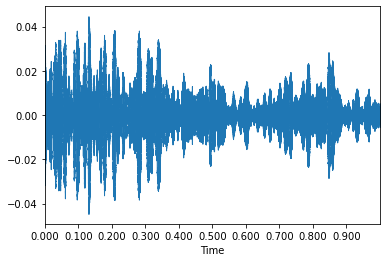

In [75]:
librosa.display.waveplot(Z[idx], sr=SAMPLE_RATE)
plt.show()

In [76]:
def plot_components(X_pca, x_str='Component 1', y_str='Component 2'):
  fig = plt.figure(1,figsize=(10,6))
  ax =  fig.add_subplot(111)
  scatter = ax.scatter(X_pca[:,0],X_pca[:,1], c=list(y))
  ax.set_xlabel(x_str)
  ax.set_ylabel(y_str)
  # ax.set_zlabel("PCA Component 3")
  ax.legend(handles=scatter.legend_elements()[0], labels=CLASSES,bbox_to_anchor=(1.3, 1.0))
  plt.show()

In [77]:
from sklearn.preprocessing import StandardScaler
X_scaled =  StandardScaler().fit_transform(X.reshape(X.shape[0],-1))

In [78]:
pca = PCA(n_components=3)
X_pca =  pca.fit_transform(X.reshape(X.shape[0],-1))

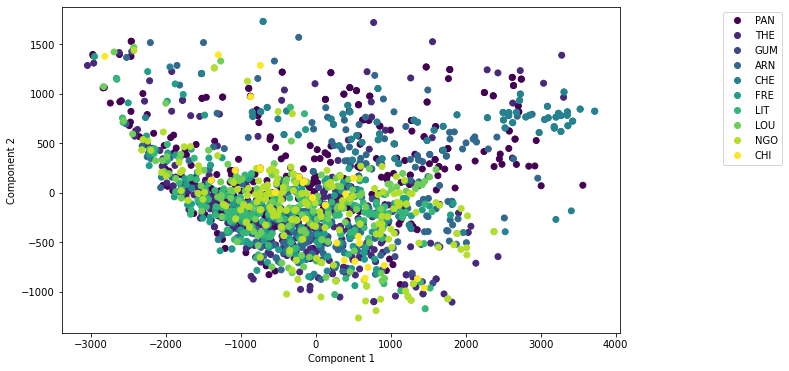

In [79]:
plot_components(X_pca)

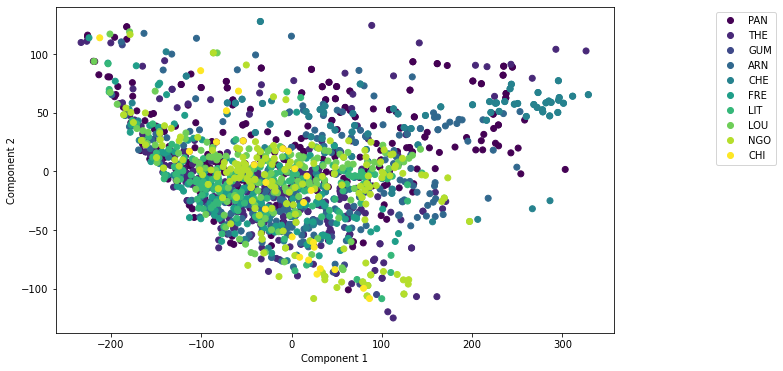

In [80]:
X_pca =  pca.fit_transform(X_scaled)
plot_components(X_pca)

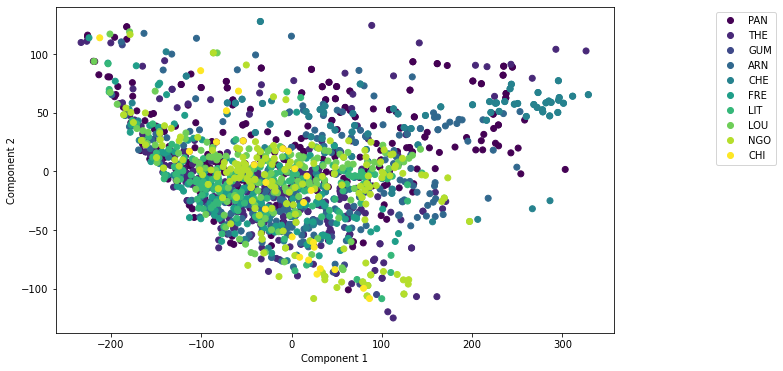

In [81]:
X_scaled =  (X - X.mean(axis=0, keepdims=True))/X.std(axis=0,keepdims=True)
X_pca =  pca.fit_transform(X_scaled.reshape(X_scaled.shape[0],-1))
plot_components(X_pca)

In [82]:
X =  X_scaled
input_shape =  (X.shape[1],X.shape[2],1)
output =  len(CLASSES)

In [83]:
X.shape

(1752, 257, 87)

In [84]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.1, shuffle=True)

In [92]:
base_model = VGG16(weights=None, include_top=False, input_shape=input_shape)
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=x)
optim_params = dict(learning_rate = 0.003,momentum = 0.9394867962846013,decay = 0.0003)
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.SGD(**optim_params),metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

# history =  model.fit(x=X_train,y=y_train, batch_size=8, epochs=20, validation_split=0.1,verbose=1)

# model.evaluate(x=X_test,y=y_test)

ResourceExhaustedError: failed to allocate memory [Op:Mul]

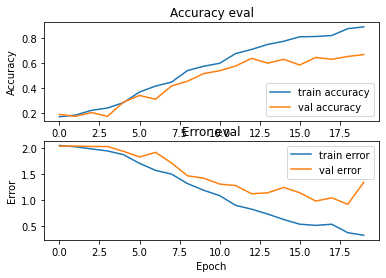

In [69]:
plot_history(history)

In [71]:
base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=x)
optim_params = dict(learning_rate = 0.003,momentum = 0.9394867962846013,decay = 0.0001)
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.SGD(**optim_params),metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")])
history =  model.fit(x=X_train,y=y_train, batch_size=8, epochs=10, validation_split=0.1,verbose=1)
model.evaluate(x=X_test,y=y_test)

Epoch 1/10
148/148 [==============================] - 45s 240ms/step - loss: 45.8122 - accuracy: 0.1546 - val_loss: 189098.6875 - val_accuracy: 0.0606
Epoch 2/10
148/148 [==============================] - 34s 232ms/step - loss: 11.7844 - accuracy: 0.1579 - val_loss: 101.1090 - val_accuracy: 0.1667
Epoch 3/10
148/148 [==============================] - 34s 232ms/step - loss: 2.5962 - accuracy: 0.2188 - val_loss: 4.0467 - val_accuracy: 0.1894
Epoch 4/10
148/148 [==============================] - 34s 232ms/step - loss: 2.0034 - accuracy: 0.2551 - val_loss: 2.8140 - val_accuracy: 0.2576
Epoch 5/10
148/148 [==============================] - 34s 232ms/step - loss: 1.9300 - accuracy: 0.2593 - val_loss: 3.1671 - val_accuracy: 0.2424
Epoch 6/10
148/148 [==============================] - 34s 233ms/step - loss: 1.8808 - accuracy: 0.2905 - val_loss: 2.4957 - val_accuracy: 0.2576
Epoch 7/10
148/148 [==============================] - 34s 232ms/step - loss: 1.8443 - accuracy: 0.3091 - val_loss: 2.4266

[2.3747975826263428, 0.2789115607738495]

In [63]:
#VGG19,ResNet50V2,EfficientNetB0
base_model = VGG19(weights=None, include_top=False, input_shape=input_shape)
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=x)
optim_params = dict(learning_rate = 0.003,momentum = 0.9394867962846013,decay = 0.0001)
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.SGD(**optim_params),metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")])
history =  model.fit(x=X_train,y=y_train, batch_size=16, epochs=10, validation_split=0.1,verbose=1)
model.evaluate(x=X_test,y=y_test)

Epoch 1/10
74/74 [==============================] - 28s 349ms/step - loss: 2.0497 - accuracy: 0.1816 - val_loss: 2.0387 - val_accuracy: 0.1742
Epoch 2/10
74/74 [==============================] - 25s 341ms/step - loss: 2.0291 - accuracy: 0.1926 - val_loss: 2.0431 - val_accuracy: 0.1742
Epoch 3/10
74/74 [==============================] - 25s 342ms/step - loss: 2.0270 - accuracy: 0.1791 - val_loss: 2.0394 - val_accuracy: 0.1742
Epoch 4/10
74/74 [==============================] - 25s 343ms/step - loss: 2.0243 - accuracy: 0.1765 - val_loss: 2.0387 - val_accuracy: 0.1742
Epoch 5/10
74/74 [==============================] - 25s 342ms/step - loss: 2.0232 - accuracy: 0.1926 - val_loss: 2.0383 - val_accuracy: 0.1742
Epoch 6/10
74/74 [==============================] - 25s 342ms/step - loss: 1.9942 - accuracy: 0.2128 - val_loss: 2.0223 - val_accuracy: 0.1742
Epoch 7/10
74/74 [==============================] - 25s 342ms/step - loss: 1.9705 - accuracy: 0.2373 - val_loss: 2.0891 - val_accuracy: 0.1894

[1.7154356241226196, 0.36054420471191406]